In [1]:
import processing as pr
from filters.blur import *
from filters.distributions import *
from filters.noise import *
from implementations.richardson_lucy import RihardsonLucy
from implementations.MAP import MAP
from algorithms.HQMotionBlurRestoration.HQMBR import HQMBR
from algorithms.HQMotionBlurRestoration.convolve  import create_line_psf

from algorithms.test_algorithm import TestAlgorithm
from algorithms.test2_algorithm import TestAlgorithm2
from algorithms.test3_algorithm import TestAlgorithm3

import cv2 as cv
import numpy as np

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tmp = pr.Processing('images','blured','restored')
tmp.read_one('3096.png')
tmp.read_one('fly.jpg')

In [3]:
fl1 = GaussianNoise(1)    #фильтры для разных шумов и смазов (см. абстрактный класс filter.FILTER_BASE)
fl2 = PoissonNoise(0.1)
fl4 = SaltAndPepperNoise([1,1,100000])
fl8 = DefocusBlur(gaussian_distribution, param=10,kernel_size = 15)
fl9 = MotionBlur(gaussian_distribution, param=10.0,angle=100,kernel_length=11)


In [4]:
shape_points = np.column_stack([[-1.0,2.0,0.0,-1.0,3.0],[0.0,2.0,-1.0,-1.5,1.5]])
intensity_points = np.column_stack([[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],[0.0,0.9,0.1,0.3,0.7,0.7,0.1,0.0,0.2,0.35,0.0]])


fl10 = BSpline_blur(shape_points=shape_points,intensity_points=intensity_points,shape_degree=2,intensity_degree=3,output_size=(15,15))

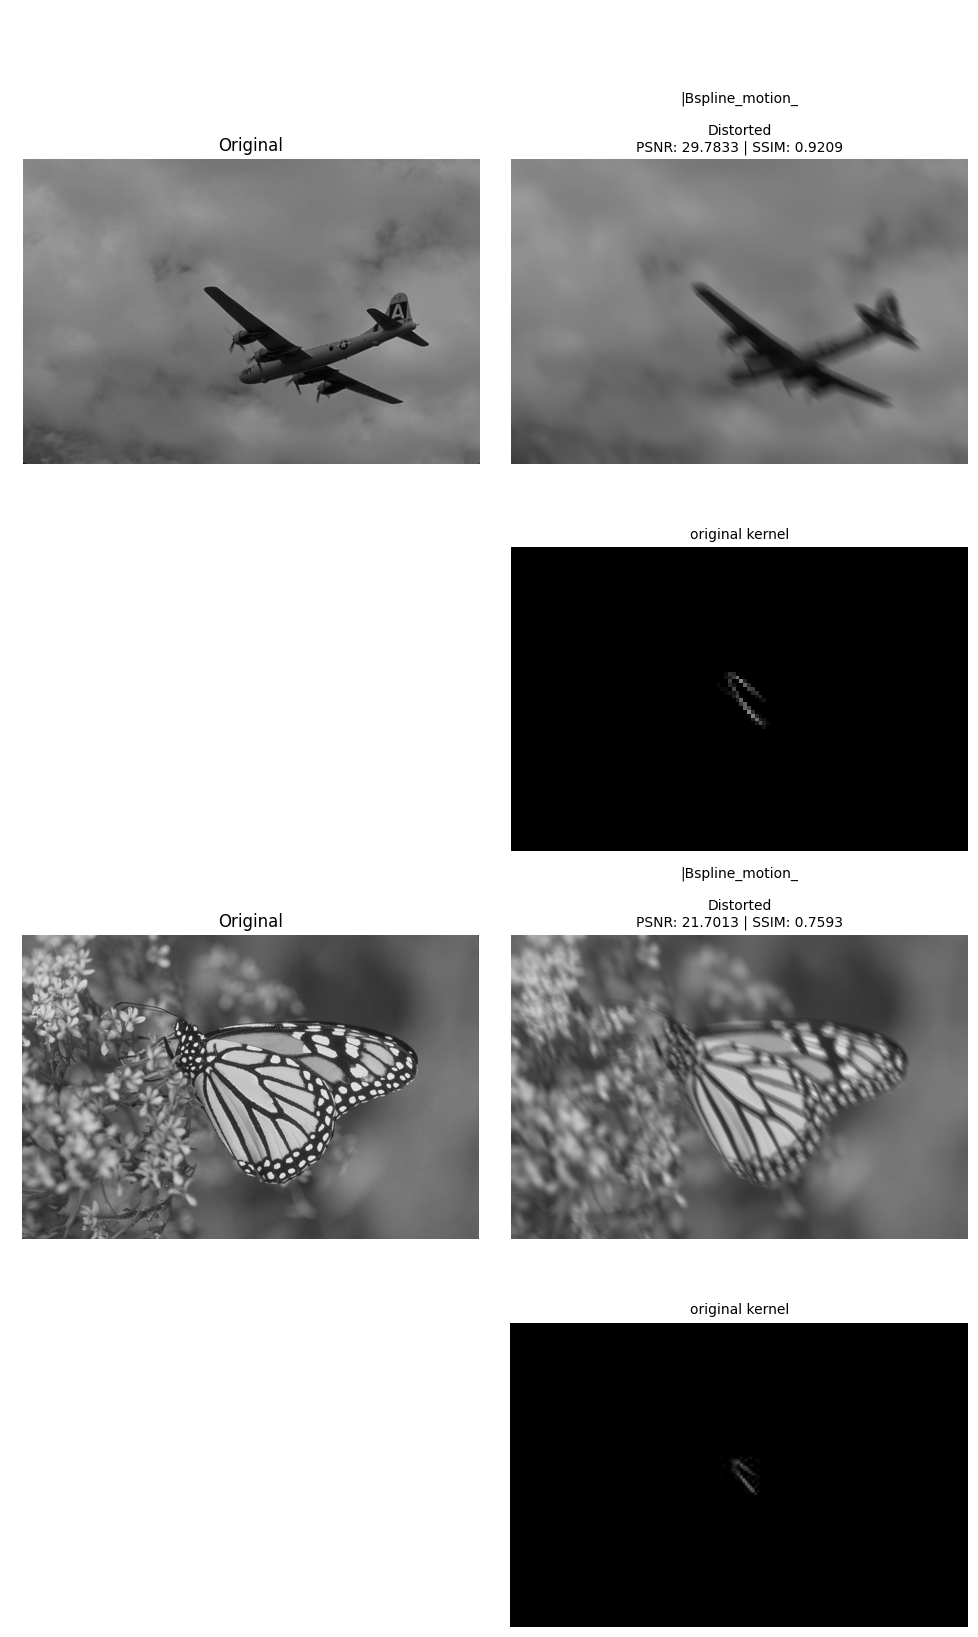

In [5]:
tmp.filter(fl10)
tmp.show(kernel_intencity_scale=10.0,kernel_size=0.25)

In [ ]:
from algorithms.jtaoz_GKPILE_Deconvolution import JtaozGKPILEDeconvolution
alg_JtaozGKPILEDeconvolution = JtaozGKPILEDeconvolution(kernel_size=31)

In [6]:
tmp.clear_output() #удаляет все привязанные отфильрованные и восстановленные картинки
tmp.reset() #в теории убирает привязку к отфильтрованным и восстановленным картинкам
tmp.clear_input() #убирает привязку ко всем загруженным картинкам (загружать надо заново)

Удален файл: blured\3096_1.png
Удален файл: blured\kernel_3096_1.png
Удален файл: blured\fly_1.jpg
Удален файл: blured\kernel_fly_1.jpg


In [7]:
# tmp.clear_output_directory() # УДАЛЯЕТ ВООБЩЕ ВСЕ из директорий с отфильрованными и восстановленными картинками + reset()

In [15]:
import argparse
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import lfilter, butter, sosfiltfilt
from PIL import Image
import cv2

def parse_arguments():
    parser = argparse.ArgumentParser(description="Generate Brownian noise for images.")
    parser.add_argument("--width", "-w", type=int, default=512, help="Width of the image in pixels.")
    parser.add_argument("--height", "-h", type=int, default=512, help="Height of the image in pixels.")
    parser.add_argument("--file_name", "-f", type=str, default="brownian_noise.png", help="Output file name.")
    parser.add_argument("--plot", "-p", action="store_true", help="Specify this flag to save analysis plots.")
    parser.add_argument("--plot_file_name", "-pf", type=str, default="noise_analysis.png", help="File name for saving the plot if plot is enabled.")
    parser.add_argument("--f3dB", "-f3", type=float, default=0.1, help="f3dB cutoff frequency (spatial frequency)")
    parser.add_argument("--highpass", "-hp", type=float, default=0.01, help="High pass filter cutoff frequency")
    parser.add_argument("--no-highpass", "-nhp", dest="do_highpass", action="store_false", help="Disable high pass filtering.")
    parser.add_argument("--color", "-c", action="store_true", help="Generate color noise (3 channels)")
    parser.add_argument("--sigma", "-s", type=float, default=1.0, help="Standard deviation for noise scaling")
    parser.set_defaults(do_highpass=True)
    return parser.parse_args()

def plot_noise_analysis(noise, file_name):
    """Save analysis plots of the generated noise."""
    print("Plotting noise analysis...")
    # sns.set(style="whitegrid")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot the noise image
    if len(noise.shape) == 3:
        # Color image - convert to grayscale for some plots
        noise_display = np.mean(noise, axis=2)
        im = axes[0, 0].imshow(noise, cmap='viridis')
    else:
        noise_display = noise
        im = axes[0, 0].imshow(noise, cmap='gray')
    
    axes[0, 0].set_title('Brownian Noise Image')
    axes[0, 0].axis('off')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Plot histogram
    axes[0, 1].hist(noise_display.flatten(), bins=50, density=True, alpha=0.7, color='blue')
    axes[0, 1].set_title('Noise Distribution')
    axes[0, 1].set_xlabel('Intensity')
    axes[0, 1].set_ylabel('Density')
    
    # Plot power spectrum
    if len(noise_display.shape) == 2:
        fft = np.fft.fft2(noise_display)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = np.log(np.abs(fft_shift) + 1e-12)
        
        im2 = axes[1, 0].imshow(magnitude_spectrum, cmap='hot')
        axes[1, 0].set_title('Power Spectrum (log scale)')
        axes[1, 0].axis('off')
        plt.colorbar(im2, ax=axes[1, 0])
    
    # Plot horizontal line profile
    center_line = noise_display[noise_display.shape[0] // 2, :]
    axes[1, 1].plot(center_line, 'b-', linewidth=1)
    axes[1, 1].set_title('Center Horizontal Profile')
    axes[1, 1].set_xlabel('X position')
    axes[1, 1].set_ylabel('Intensity')
    
    plt.tight_layout()
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Analysis plot saved as {file_name}")

def spatial_high_pass_filter(image, cutoff_freq):
    """Apply high pass filter in spatial domain."""
    print("Applying spatial high pass filter...")
    
    if len(image.shape) == 3:
        # Color image - filter each channel separately
        filtered = np.zeros_like(image)
        for i in range(image.shape[2]):
            filtered[:, :, i] = spatial_high_pass_filter_2d(image[:, :, i], cutoff_freq)
        return filtered
    else:
        return spatial_high_pass_filter_2d(image, cutoff_freq)

def spatial_high_pass_filter_2d(image, cutoff_freq):
    """Apply high pass filter to 2D image."""
    # Create butterworth high-pass filter in frequency domain
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # Create distance matrix from center
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    
    # Create high-pass butterworth filter
    order = 2
    H = 1 / (1 + (cutoff_freq / (D + 1e-12))** (2 * order))
    H = 1 - H  # Convert to high-pass
    
    # Apply filter in frequency domain
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fshift_filtered = fshift * H
    f_filtered = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.real(np.fft.ifft2(f_filtered))
    
    return image_filtered

def find_alpha_spatial(f3dB, max_freq=0.5):
    """
    Calculate the alpha value for spatial brownian noise.
    
    Adapted for 2D spatial frequencies.
    """
    print(f"Calculating alpha for spatial cutoff frequency {f3dB}...")
    normalized_f3dB = f3dB / max_freq
    return (
        np.sqrt(
            np.power(np.cos(2 * np.pi * normalized_f3dB), 2) 
            - 4 * np.cos(2 * np.pi * normalized_f3dB) 
            + 3
        ) 
        + np.cos(2 * np.pi * normalized_f3dB) 
        - 1
    )

def generate_2d_brownian_noise(width, height, alpha):
    """
    Generate 2D brownian noise by applying 1D brownian noise in both dimensions.
    """
    print("Generating 2D Brownian noise...")
    
    # Generate white noise
    white_noise = np.random.normal(0, 1, (height, width))
    
    # Apply brownian filter in row direction
    b = [alpha]
    a = [1, -(1 - alpha)]
    
    brownian_2d = np.zeros_like(white_noise)
    
    # Filter each row
    for i in range(height):
        brownian_2d[i, :] = lfilter(b, a, white_noise[i, :])
    
    # Filter each column of the result
    for j in range(width):
        brownian_2d[:, j] = lfilter(b, a, brownian_2d[:, j])
    
    return brownian_2d

def generate_color_brownian_noise(width, height, alpha):
    """Generate color brownian noise (3 channels)."""
    print("Generating color Brownian noise...")
    color_noise = np.zeros((height, width, 3))
    
    for channel in range(3):
        # Add some correlation between channels for more natural color noise
        base_noise = np.random.normal(0, 1, (height, width))
        if channel > 0:
            # Correlate channels with previous ones
            correlation = 0.7
            base_noise = correlation * color_noise[:, :, channel-1] + \
                        np.sqrt(1 - correlation**2) * base_noise
        
        # Apply 2D brownian filter
        channel_noise = generate_2d_brownian_noise_from_base(base_noise, alpha)
        color_noise[:, :, channel] = channel_noise
    
    return color_noise

def generate_2d_brownian_noise_from_base(base_noise, alpha):
    """Generate 2D brownian noise from given base noise."""
    height, width = base_noise.shape
    b = [alpha]
    a = [1, -(1 - alpha)]
    
    brownian_2d = np.zeros_like(base_noise)
    
    # Filter each row
    for i in range(height):
        brownian_2d[i, :] = lfilter(b, a, base_noise[i, :])
    
    # Filter each column of the result
    for j in range(width):
        brownian_2d[:, j] = lfilter(b, a, brownian_2d[:, j])
    
    return brownian_2d

def normalize_noise(noise, sigma=1.0):
    """Normalize noise to desired standard deviation."""
    print("Normalizing noise...")
    if len(noise.shape) == 3:
        # Color image - normalize each channel separately but maintain relationships
        current_std = np.std(noise)
        normalized = (noise / current_std) * sigma
    else:
        current_std = np.std(noise)
        normalized = (noise / current_std) * sigma
    
    return normalized

def save_noise_image(noise, file_name):
    """Save noise as image file."""
    print(f"Saving noise image as {file_name}...")
    
    if len(noise.shape) == 3:
        # Color image - convert to 8-bit
        noise_8bit = np.clip(noise * 127.5 + 127.5, 0, 255).astype(np.uint8)
        image = Image.fromarray(noise_8bit, 'RGB')
    else:
        # Grayscale image
        noise_8bit = np.clip(noise * 127.5 + 127.5, 0, 255).astype(np.uint8)
        image = Image.fromarray(noise_8bit, 'L')
    
    image.save(file_name)
    print(f"Image saved as {file_name}")

def main():
    f3dB = 0.1
    color=True
    width=512
    height=512
    do_highpass=True
    highpass=0.01
    sigma=1.0
    file_name="brownian_noise.png"
    plot=True
    plot_file_name="noise_analysis.png"

    # Calculate alpha for spatial frequencies
    alpha = find_alpha_spatial(f3dB)
    print(f"Calculated alpha: {alpha}")
    
    # Generate brownian noise
    if color:
        brownian_noise = generate_color_brownian_noise(width, height, alpha)
    else:
        brownian_noise = generate_2d_brownian_noise(width, height, alpha)
    
    # Apply high-pass filter if requested
    if do_highpass:
        brownian_noise = spatial_high_pass_filter(brownian_noise, highpass)
    
    # Normalize noise
    brownian_noise = normalize_noise(brownian_noise, sigma)
    
    print(f"Noise statistics: mean={np.mean(brownian_noise):.3f}, std={np.std(brownian_noise):.3f}")
    
    # Save the noise image
    save_noise_image(brownian_noise, file_name)
    
    # Generate analysis plots if requested
    if plot:
        plot_noise_analysis(brownian_noise, plot_file_name)

main()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1230371100126115..0.2127019439277055].


Calculating alpha for spatial cutoff frequency 0.1...
Calculated alpha: 0.6726238018208242
Generating color Brownian noise...
Applying spatial high pass filter...
Normalizing noise...
Noise statistics: mean=-1.168, std=1.000
Saving noise image as brownian_noise.png...
Image saved as brownian_noise.png
Plotting noise analysis...
Analysis plot saved as noise_analysis.png


In [26]:
import numpy as np
from PIL import Image

def add_brownian_noise_to_image(input_image_path, output_image_path, 
                               noise_strength=0.3, alpha=0.1, 
                               do_highpass=True, highpass_cutoff=0.01):
    """
    Накладывает коричневый шум на существующее изображение.
    
    Parameters:
    -----------
    input_image_path : str
        Путь к исходному изображению
    output_image_path : str
        Путь для сохранения результата
    noise_strength : float
        Сила наложения шума (0.0 - 1.0)
    alpha : float
        Параметр альфа для коричневого шума
    """
    
    # Загружаем исходное изображение
    original_image = Image.open(input_image_path).convert('L')
    # original_image = cv.imread(input_image_path,cv.IMREAD_GRAYSCALE)

    img_array = np.array(original_image, dtype=np.float32) / 255.0
    # img_array = np.array(original_image, dtype=np.float32)

    
    # Генерируем коричневый шум того же размера
    height, width = img_array.shape[0], img_array.shape[1]
    
    if len(img_array.shape) == 3:
        # Цветное изображение
        brownian_noise = generate_color_brownian_noise(width, height, alpha)
    else:
        # Черно-белое изображение
        brownian_noise = generate_2d_brownian_noise(width, height, alpha)
    
    # Применяем high-pass фильтр если нужно
    if do_highpass:
        brownian_noise = spatial_high_pass_filter(brownian_noise, highpass_cutoff)
    
    # Нормализуем шум
    brownian_noise = normalize_noise(brownian_noise, sigma=1.0)
    
    # Накладываем шум на изображение
    if len(img_array.shape) == 3:
        # Для цветного изображения - накладываем на каждый канал
        noisy_image = img_array + noise_strength * brownian_noise
    else:
        # Для черно-белого
        noisy_image = img_array + noise_strength * brownian_noise
    
    # Обрезаем значения до [0, 1] и конвертируем обратно в uint8
    noisy_image = np.clip(noisy_image, 0, 1)
    noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)
    
    # Сохраняем результат
    result_image = Image.fromarray(noisy_image_uint8)
    result_image.save(output_image_path)
    print(f"Изображение с шумом сохранено как: {output_image_path}")

# Нужно добавить эти функции из предыдущего кода:
def generate_2d_brownian_noise(width, height, alpha):
    """Генерация 2D коричневого шума"""
    white_noise = np.random.normal(0, 1, (height, width))
    b = [alpha]
    a = [1, -(1 - alpha)]
    
    brownian_2d = np.zeros_like(white_noise)
    
    for i in range(height):
        brownian_2d[i, :] = lfilter(b, a, white_noise[i, :])
    
    for j in range(width):
        brownian_2d[:, j] = lfilter(b, a, brownian_2d[:, j])
    
    return brownian_2d

def generate_color_brownian_noise(width, height, alpha):
    """Генерация цветного коричневого шума"""
    color_noise = np.zeros((height, width, 3))
    
    for channel in range(3):
        base_noise = np.random.normal(0, 1, (height, width))
        if channel > 0:
            correlation = 0.7
            base_noise = correlation * color_noise[:, :, channel-1] + \
                        np.sqrt(1 - correlation**2) * base_noise
        
        channel_noise = generate_2d_brownian_noise_from_base(base_noise, alpha)
        color_noise[:, :, channel] = channel_noise
    
    return color_noise

def generate_2d_brownian_noise_from_base(base_noise, alpha):
    """Генерация 2D шума из базового шума"""
    height, width = base_noise.shape
    b = [alpha]
    a = [1, -(1 - alpha)]
    
    brownian_2d = np.zeros_like(base_noise)
    
    for i in range(height):
        brownian_2d[i, :] = lfilter(b, a, base_noise[i, :])
    
    for j in range(width):
        brownian_2d[:, j] = lfilter(b, a, brownian_2d[:, j])
    
    return brownian_2d

def spatial_high_pass_filter(image, cutoff_freq):
    """Фильтр высоких частот"""
    if len(image.shape) == 3:
        filtered = np.zeros_like(image)
        for i in range(image.shape[2]):
            filtered[:, :, i] = spatial_high_pass_filter_2d(image[:, :, i], cutoff_freq)
        return filtered
    else:
        return spatial_high_pass_filter_2d(image, cutoff_freq)

def spatial_high_pass_filter_2d(image, cutoff_freq):
    """2D фильтр высоких частот"""
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    
    order = 2
    H = 1 / (1 + (cutoff_freq / (D + 1e-12))** (2 * order))
    H = 1 - H
    
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fshift_filtered = fshift * H
    f_filtered = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.real(np.fft.ifft2(f_filtered))
    
    return image_filtered

def normalize_noise(noise, sigma=1.0):
    """Нормализация шума"""
    if len(noise.shape) == 3:
        current_std = np.std(noise)
        normalized = (noise / current_std) * sigma
    else:
        current_std = np.std(noise)
        normalized = (noise / current_std) * sigma
    
    return normalized

In [59]:
import numpy as np
from PIL import Image
from scipy.signal import lfilter

def convert_to_grayscale(image_path):
    """Конвертирует изображение в черно-белое."""
    image = Image.open(image_path).convert('L')
    return image

def generate_2d_brownian_noise(width, height, alpha):
    """Генерация 2D коричневого шума для черно-белых изображений."""
    white_noise = np.random.normal(0, 1, (height, width))
    b = [alpha]
    a = [1, -(1 - alpha)]
    
    brownian_2d = np.zeros_like(white_noise)
    
    # Фильтруем по строкам
    for i in range(height):
        brownian_2d[i, :] = lfilter(b, a, white_noise[i, :])
    
    # Фильтруем по столбцам
    for j in range(width):
        brownian_2d[:, j] = lfilter(b, a, brownian_2d[:, j])
    
    return brownian_2d

def spatial_high_pass_filter_2d(image, cutoff_freq):
    """2D фильтр высоких частот для черно-белых изображений."""
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    # Создаем частотную сетку
    u = np.arange(rows) - crow
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(v, u)
    D = np.sqrt(U**2 + V**2)
    
    # Создаем butterworth high-pass фильтр
    order = 2
    H = 1 / (1 + (cutoff_freq / (D + 1e-12)) ** (2 * order))
    H = 1 - H  # Преобразуем в high-pass
    
    # Применяем фильтр в частотной области
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    fshift_filtered = fshift * H
    f_filtered = np.fft.ifftshift(fshift_filtered)
    image_filtered = np.real(np.fft.ifft2(f_filtered))
    
    return image_filtered

def normalize_noise(noise, sigma=1.0):
    """Нормализация шума."""
    current_std = np.std(noise)
    normalized = (noise / current_std) * sigma
    return normalized

def add_brownian_noise_to_grayscale(input_image_path, output_image_path, 
                                   noise_strength=0.3, alpha=0.1, 
                                   do_highpass=True, highpass_cutoff=0.01):
    """
    Накладывает коричневый шум на черно-белое изображение.
    
    Parameters:
    -----------
    input_image_path : str
        Путь к исходному изображению
    output_image_path : str
        Путь для сохранения результата
    noise_strength : float
        Сила наложения шума (0.0 - 1.0)
    alpha : float
        Параметр альфа для коричневого шума
    do_highpass : bool
        Применять ли high-pass фильтр
    highpass_cutoff : float
        Частота среза для high-pass фильтра
    """
    
    # Загружаем и конвертируем в черно-белое
    print("Загружаем и конвертируем изображение в черно-белое...")
    grayscale_image = convert_to_grayscale(input_image_path)
    img_array = np.array(grayscale_image, dtype=np.float32) / 255.0
    
    height, width = img_array.shape
    
    # Генерируем коричневый шум того же размера
    print("Генерируем коричневый шум...")
    brownian_noise = generate_2d_brownian_noise(width, height, alpha)
    
    # Применяем high-pass фильтр если нужно
    if do_highpass:
        print("Применяем high-pass фильтр...")
        brownian_noise = spatial_high_pass_filter_2d(brownian_noise, highpass_cutoff)
    
    # Нормализуем шум
    brownian_noise = normalize_noise(brownian_noise, sigma=1.0)
    
    # Накладываем шум на изображение
    print("Накладываем шум...")
    noisy_image = img_array + noise_strength * brownian_noise
    
    # Обрезаем значения до [0, 1] и конвертируем обратно в uint8
    noisy_image = np.clip(noisy_image, 0, 1)
    noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)
    
    # Сохраняем результат
    result_image = Image.fromarray(noisy_image_uint8, 'L')
    result_image.save(output_image_path)
    print(f"Черно-белое изображение с шумом сохранено как: {output_image_path}")

def multiply_brownian_noise_grayscale(input_image_path, output_image_path, 
                                     noise_strength=0.5, alpha=0.1):
    """
    Умножает черно-белое изображение на коричневый шум для создания текстуры.
    """
    # Загружаем и конвертируем в черно-белое
    grayscale_image = convert_to_grayscale(input_image_path)
    img_array = np.array(grayscale_image, dtype=np.float32) / 255.0
    
    height, width = img_array.shape
    
    # Генерируем шум
    brownian_noise = generate_2d_brownian_noise(width, height, alpha)
    
    # Нормализуем и масштабируем шум для умножения
    brownian_noise = normalize_noise(brownian_noise, sigma=0.5)
    brownian_noise = 1.0 + noise_strength * brownian_noise
    
    # Умножаем изображение на шум
    textured_image = img_array * brownian_noise
    
    # Обрезаем и сохраняем
    textured_image = np.clip(textured_image, 0, 1)
    # textured_image_uint8 = (textured_image * 255).astype(np.uint8)
    textured_image_uint8 = (textured_image * 200).astype(np.uint8)

    
    result_image = Image.fromarray(textured_image_uint8, 'L')
    result_image.save(output_image_path)
    print(f"Текстурированное черно-белое изображение сохранено как: {output_image_path}")

In [60]:
add_brownian_noise_to_image('images\\3096.png', "blured\\brown_noise_3096.png", noise_strength=0.1, alpha=0.1, do_highpass=True, highpass_cutoff=0.01)

Изображение с шумом сохранено как: blured\brown_noise_3096.png
